A2 - IVC

Bargav Jagatha

U80005052


Mounika Chowdary Akuraju

U70197123

In [ ]:
import cv2
import numpy as np

In [37]:
video = cv2.VideoCapture(0)


while True:
    ret, frame = video.read()
        
    cv2.imshow("Gesture Recognition", frame)
    
    if cv2.waitKey(1) == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

cv2.waitKey(1)


-1

In [38]:
cv2.imwrite('temp.png', frame)

True

In [39]:
def erosion(image_cv, kernel_size = 4):
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size,kernel_size))
    image_cv_eroded = cv2.erode(image_cv, kernel)
    
    return image_cv_eroded

def dilate(image_cv, kernel_size = 4):
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size,kernel_size))
    image_cv_dilated = cv2.dilate(image_cv, kernel)
    
    return image_cv_dilated

def morph_image(image,morph, kernel_size):
    
    if morph == 'dilate':
        image_morphed = dilate(image,kernel_size = kernel_size)
        
    elif morph == 'erode':
        image_morphed = erosion(image,kernel_size = kernel_size)
    else:
        raise NotImplementedError
    return image_morphed

In [40]:

def get_contours(cv_image_thres):
    
    contours, hierarchy = cv2.findContours(cv_image_thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_contours(cv_image, contours,fill='line'):
    
    if fill=='solid':
        cv_image_out = cv2.drawContours(cv_image, contours, -1,(0,255,0),cv2.FILLED)
    else:
        cv_image_out = cv2.drawContours(cv_image, contours, -1,(0,255,0), 3)
        
    return cv_image_out

def get_largest_contour(contours):
    
    max_area = 0
    
    max_i = -1
    
    for i,contour in enumerate(contours):
        
        area = cv2.contourArea(contour)
        
        if area > max_area:
            max_i = i
            max_area = area
            
    return [contours[max_i]]

In [41]:
def detect_skin(frame):
    ycrcb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)

    lower_skin = np.array([0, 145, 100], dtype=np.uint8)
    upper_skin = np.array([255, 173, 127], dtype=np.uint8)

    mask = cv2.inRange(ycrcb, lower_skin, upper_skin)
    
    mask = morph_image(mask, morph='erode', kernel_size=3)
    mask =  morph_image(mask, morph='dilate', kernel_size=3)

    return mask

In [42]:
def circularity(contour):

    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if perimeter == 0:
        circularity = 0
    else:
        circularity = (4 * np.pi * area) / (perimeter ** 2)

    return circularity

In [43]:
import matplotlib.pyplot as plt

def show_image(image):
    
    if image.ndim == 3:
    
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        plt.imshow(img)
        
    else:
        plt.imshow(image, cmap = 'gray')
    

In [44]:
frame_skind = detect_skin(frame)

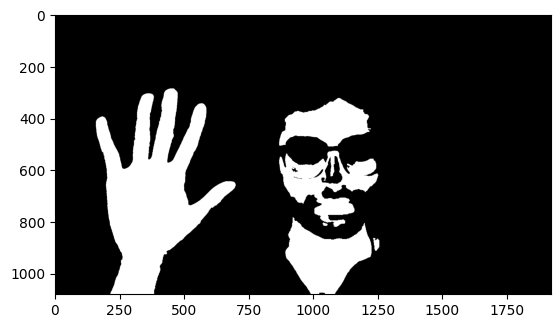

In [45]:
show_image(frame_skind)

In [46]:
cv2.imwrite('temp_skind.png', frame_skind)

True

In [47]:

skin_contours = get_contours(frame_skind)

largest_skincontour = get_largest_contour(skin_contours)


binary_frame = np.zeros(frame.shape[:2], dtype=np.uint8)

binary_frame += 255

binary_frame = cv2.drawContours(binary_frame, largest_skincontour, -1, (0), thickness=cv2.FILLED)


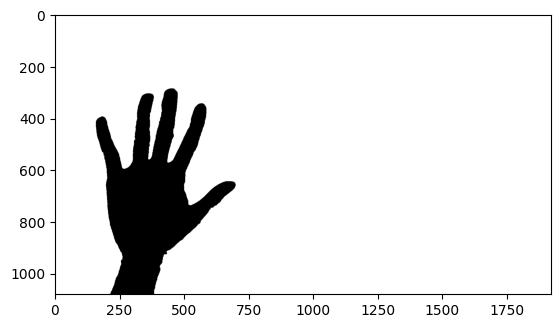

In [48]:
show_image(binary_frame)

In [49]:
cv2.imwrite('temp_hand.png', binary_frame)

True

In [50]:
def match_gestures(bin_frame, templates, score_threshold=0.5):
    best_match = None
    highest_score = 0  

    for template_name, template in templates:
        if template is None:
            continue 
        
        if template.shape[0] > bin_frame.shape[0] or template.shape[1] > bin_frame.shape[1]:
            scale_factor = min(bin_frame.shape[0] / template.shape[0], bin_frame.shape[1] / template.shape[1])
            new_size = (int(template.shape[1] * scale_factor), int(template.shape[0] * scale_factor))
            resized_template = cv2.resize(template, new_size, interpolation=cv2.INTER_AREA)
        else:
            resized_template = template

        res = cv2.matchTemplate(bin_frame, resized_template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)

        if max_val > highest_score:
            highest_score = max_val
            best_match = (template_name, template, max_loc, max_val)

    if best_match and highest_score > score_threshold:
        return [best_match]
    else:
        return []


def annotate_frame(frame, matching_results):
    for template_name, template, loc, _ in matching_results:
        top_left = loc
        bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
        cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
        cv2.putText(frame, template_name, top_left, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

In [51]:
templates = [
             ('thumbsup', cv2.imread('templates/thumbsup_bintemplate.png', cv2.IMREAD_GRAYSCALE) ),

             ('thumbsup', cv2.imread('templates/thumbsup_bintemplate5.png', cv2.IMREAD_GRAYSCALE) ),

             ('thumbsdown', cv2.imread('templates/thumbsdown_bintemplate.png', cv2.IMREAD_GRAYSCALE)),
             ('thumbsdown', cv2.imread('templates/thumbsdown_bintemplate4.png', cv2.IMREAD_GRAYSCALE)),

             ('peace', cv2.imread('templates/peace_bintemplate1.png', cv2.IMREAD_GRAYSCALE)),
             ('peace', cv2.imread('templates/peace_bintemplate2.png', cv2.IMREAD_GRAYSCALE)),

             ('hand open', cv2.imread('templates/fullhand_bintemplate1.png', cv2.IMREAD_GRAYSCALE)),

             ('hand open', cv2.imread('templates/fullhand_bintemplate2.png', cv2.IMREAD_GRAYSCALE)),

             
             ]



In [52]:
if circularity(largest_skincontour[0]) >= 0.4:
    cv2.putText(frame, "Hand Closed", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
else:

    binary_frame = np.zeros(frame.shape[:2], dtype=np.uint8)

    binary_frame += 255

    binary_frame = cv2.drawContours(binary_frame, largest_skincontour, -1, (0), thickness=cv2.FILLED)

    matching_results = match_gestures(binary_frame, templates)

    annotate_frame(frame, matching_results)


    



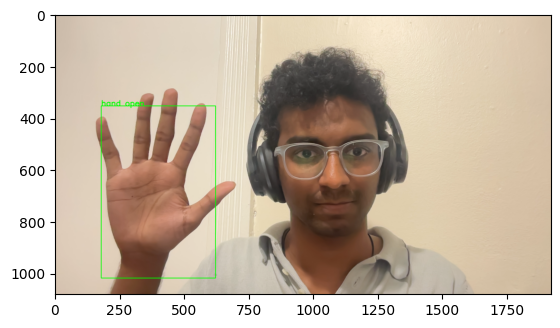

In [53]:
cv2.imwrite('temp_ann.png', frame)

show_image(frame)

In [15]:
video = cv2.VideoCapture(0)



# Initialize variables for tracking the hand's centroid position
centroid_positions = []
wave_detected = False
min_distance = 30  
min_direction_changes = 4
direction_change_indices = []

# templates = [('thumbsup', cv2.imread('thumbsup_bintemplate.png', cv2.IMREAD_GRAYSCALE) ), ('thumbsdown', cv2.imread('thumbsdown_bintemplate.png', cv2.IMREAD_GRAYSCALE) )]

skip_frames = 3

frame_cnt = 0

frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'MP4V') 
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (frame_width, frame_height))

while True:
    ret, frame = video.read()

    frame_cnt += 1

    if frame_cnt%skip_frames == 0:
        continue


    image_skinmasked = detect_skin(frame)

    skin_contours = get_contours(image_skinmasked)

    if len(skin_contours) == 0:
        continue

    largest_skincontour = get_largest_contour(skin_contours)


    if circularity(largest_skincontour[0]) >= 0.4:
        cv2.putText(frame, "Hand Closed", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    else:

        binary_frame = np.zeros(frame.shape[:2], dtype=np.uint8)

        binary_frame += 255

        binary_frame = cv2.drawContours(binary_frame, largest_skincontour, -1, (0), thickness=cv2.FILLED)

        matching_results = match_gestures(binary_frame, templates)

        annotate_frame(frame, matching_results)

    M = cv2.moments(largest_skincontour[0])
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroid_positions.append((cx, cy))

    centroid_positions = centroid_positions[-10:]

    if len(centroid_positions) > 1:
        dx = centroid_positions[-1][0] - centroid_positions[-2][0]
        if abs(dx) >= min_distance:
            if len(direction_change_indices) == 0 or centroid_positions[-2][0] != direction_change_indices[-1]:
                direction_change_indices.append(centroid_positions[-2][0])
            if len(direction_change_indices) >= min_direction_changes:
                wave_detected = True
                direction_change_indices = []  # Reset after detecting a wave
            else:
                wave_detected = False
        if wave_detected:
            cv2.putText(frame, "Wave Detected", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
        else:
            wave_detected = False

    out.write(frame)
        
    cv2.imshow("Gesture Recognition", frame)
    
    if cv2.waitKey(1) == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

cv2.waitKey(1)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


-1